In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy import sparse
from scipy.sparse.linalg import eigs, eigsh
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

# Introduction (1-D):

The Time-Independent Schrödinger Equation is $$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2}+V(x)\psi=E\psi$$ for a confined quantum particle in 1 dimension, with the Boundary Conditions $\psi(0)=\psi(L)=0$, an example of a **Regular Sturm-Liouville Eigenvalue Problem,** where 

- There exist an infinite set of real Eigenenergies $E_0<E_1<E_2...$ with the smallest Eigenenergy being $E_0$.
- The corresponding Eigenfunctions $\psi_0,\psi_1...$ are complete, meaning any piecewise smooth function $f(x)$ on $[0,L]$ can be constructed as a linear combination $f(x)\sim\sum_ia_i\psi_i$ of them.
- These Eigenfunctions are orthogonal, thus $\int_0^L\psi_i(x)\psi_j(x)\,dx=0$ when $i\neq j$.

The **Infinite Square Well** is a particular case of a confined quantum particle when $V=0$. Here, we have $$\psi_n=\sqrt\frac 2L\sin\bigg(\frac{n\pi x}L\bigg)$$ $$E_n=\frac{n^2\pi^2\hbar^2}{2mL^2}$$ In general, when $V$ is nonzero the Eigenfunctions $\psi_n$ are more complex but are also orthogonal and complete, as guaranteed by the Sturm-Liouville Theorem.

We'll now examine the usage of numerical techniques to find the Eigenfunctions as well as the Eigenenergies for a general case of nonzero potential.

# Mathematical Formulation:

Using the common convention $\hbar=1$ to set our units, and multiplying our equation by $m$:$$-\frac 12\frac{d^2\psi}{dx^2}+mV(x)\psi=mE\psi$$ We still have the $x$ quantity in the derivative, so we'll substitute some $z=x/L$, yielding $$-\frac 12\frac{d^2\psi}{dz^2}+mL^2V(z)\psi=mL^2E\psi$$ and of course, $\psi(z=0)=\psi(z=1)=0$. This is much easier to tackle numerically now, we're just required to define $mL^2V$ as opposed to just $V$.


In discrete form, this becomes approximately $$\frac{d^2f}{dx^2}\bigg|_{x=k\delta x}=\frac{f_{k+1}+f_{k-1}-2f_k}{\delta x^2}$$ where $f_k\equiv f(k\delta x)$, using discrete intervals $\delta z$. This can be rewritten as $$-\frac 12\frac{\psi_{k+1}+\psi_{k-1}-2\psi_k}{\delta z^2}+mL^2V_k\psi_k=mL^2E\psi_k$$ and so $$-\frac 1{2\delta z^2}\psi_{k+1}+\bigg(\frac 1{\delta z^2}+mL^2V_k\bigg)\psi_k-\frac 1{2\delta z^2}\psi_{k-1}=mL^2E\psi_j$$

This is essentially a large system of linear equations: 
- $\displaystyle-\frac 1{2\delta z^2}\psi_{2}+\bigg(\frac 1{\delta z^2}+mL^2V_1\bigg)\psi_1-\frac 1{2\delta z^2}\psi_{0}=mL^2E\psi_1$ for $k=1$,
- $\displaystyle-\frac 1{2\delta z^2}\psi_{3}+\bigg(\frac 1{\delta z^2}+mL^2V_2\bigg)\psi_2-\frac 1{2\delta z^2}\psi_{1}=mL^2E\psi_2$ for $k=2$, 

...all until we get to $\displaystyle-\frac 1{2\delta z^2}\psi_{N}+\bigg(\frac 1{\delta z^2}+mL^2V_{N-1}\bigg)\psi_{N-1}-\frac 1{2\delta z^2}\psi_{N-2}=mL^2E\psi_{N-1}$ for $k=N$ where $N=\delta y^{-1}$ is the number of poimts we use in the interval $z\in [0,1]$.

This can be expressed as a Tridiagonal Matrix when we recall the Boundary Conditions $\psi_0=\psi_N=0$:$$\large\begin{bmatrix}\frac 1{\delta z^2}+mL^2V_1&-\frac 1{2\delta z^2}&0&0...\\-\frac 1{2\delta z^2}&\frac 1{\delta z^2}+mL^2V_2&-\frac 1{2\delta z^2}&0...\\...&...&...&-\frac 1{2\delta z^2}\\... 0&0&-\frac 1{2\delta z^2}&\frac 1{\delta z^2}+mL^2V_{N-1}\end{bmatrix}\begin{bmatrix}\psi_1\\\psi_2\\\psi_3\\\psi_{N-1}\end{bmatrix}=mL^2E\begin{bmatrix}\psi_1\\\psi_2\\...\\\psi_{N-1}\end{bmatrix}$$ To solve this problem, we just need the Eigensolutions to the left-hand matrix. A **Toeplitz Matrix** could be of use here, a kind of tridiagonal matrix where the elements on each diagonal are the same. 

We'll start by defining $N$ and $\delta z$, and then $z$ and the term $mL^2V$ (which we'll call the *Potential Product*):

Text(0, 0.5, '$mL^2V(z)$ [V kg $\\mathrm{m}^2$]')

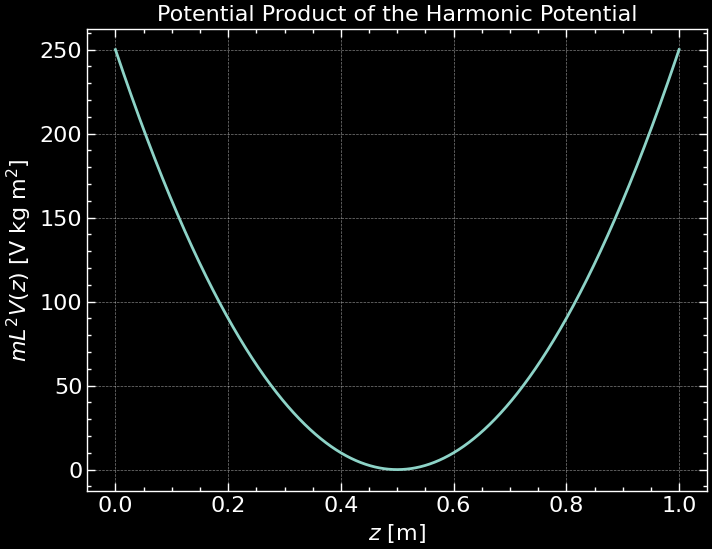

In [5]:
N = 2000
dz = 1 / N

z = np.linspace(0, 1, N + 1)
def pot_prod(z):
    return 1000 * (z - 1 / 2) ** 2

plt.plot(z, pot_prod(z))
plt.title('Potential Product of the Harmonic Potential')
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$mL^2V(z)$ [V kg $\mathrm{m}^2$]')

In [6]:
d = dz ** (-2) + pot_prod(z)[1:-1]
e = -0.5 * dz ** (-2) * np.ones(len(d) - 1)

w, v = eigh_tridiagonal(d, e)
v

array([[ 3.44542180e-06,  1.45430085e-05,  4.02899950e-05, ...,
        -1.97736494e-04,  2.99255038e-04, -2.98292039e-04],
       [ 6.89123488e-06,  2.90873432e-05,  8.05827560e-05, ...,
         3.95448954e-04, -5.98485517e-04,  5.96559612e-04],
       [ 1.03378289e-05,  4.36343230e-05,  1.20881029e-04, ...,
        -5.93113448e-04,  8.97667030e-04, -8.94778406e-04],
       ...,
       [ 1.03378289e-05, -4.36343230e-05,  1.20881029e-04, ...,
        -5.93113448e-04, -8.97667030e-04, -8.94778406e-04],
       [ 6.89123488e-06, -2.90873432e-05,  8.05827560e-05, ...,
         3.95448954e-04,  5.98485517e-04,  5.96559612e-04],
       [ 3.44542180e-06, -1.45430085e-05,  4.02899950e-05, ...,
        -1.97736494e-04, -2.99255038e-04, -2.98292039e-04]])

Plotting the Eigenfunctions and the Probability Densities:

Text(0, 0.5, '$\\psi_i(z)$')

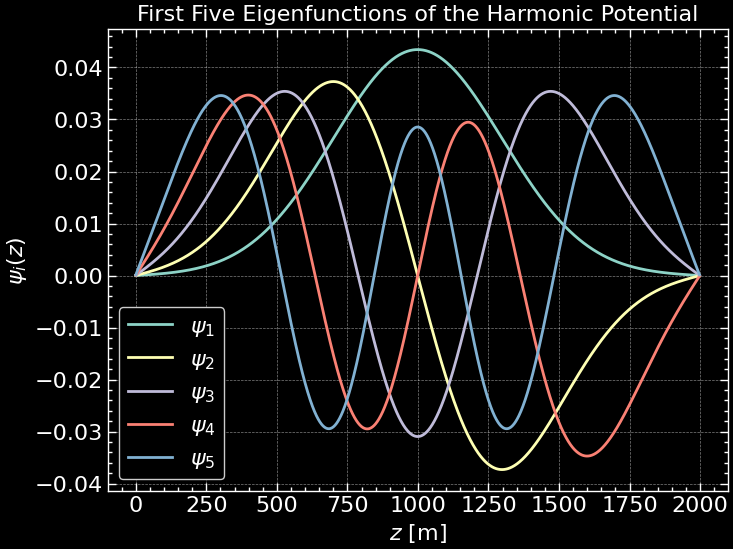

In [7]:
plt.plot(v.T[0], label = r'$\psi_1$')
plt.plot(v.T[1], label = r'$\psi_2$')
plt.plot(v.T[2], label = r'$\psi_3$')
plt.plot(v.T[3], label = r'$\psi_4$')
plt.plot(v.T[4], label = r'$\psi_5$')

plt.title('First Five Eigenfunctions of the Harmonic Potential')
plt.legend()
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$\psi_i(z)$')

Text(0, 0.5, '$|\\psi_i(z)|^2$')

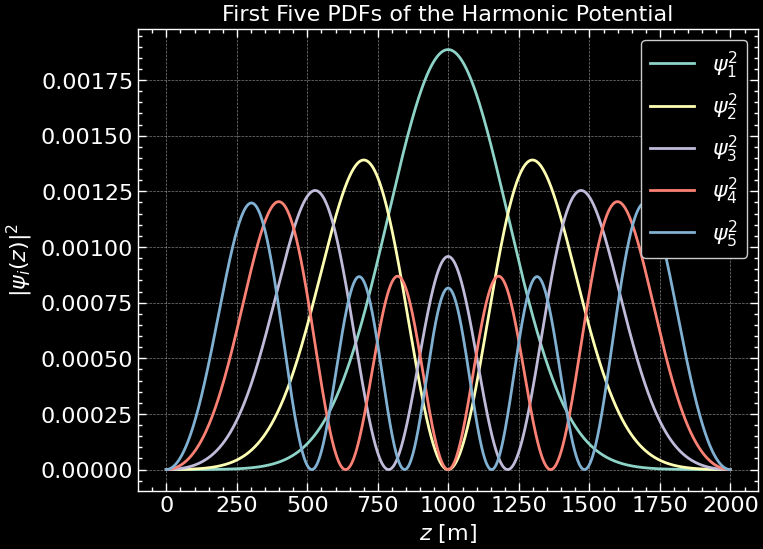

In [8]:
plt.plot(v.T[0] ** 2, label = r'$\psi_1^2$')
plt.plot(v.T[1] ** 2, label = r'$\psi_2^2$')
plt.plot(v.T[2] ** 2, label = r'$\psi_3^2$')
plt.plot(v.T[3] ** 2, label = r'$\psi_4^2$')
plt.plot(v.T[4] ** 2, label = r'$\psi_5^2$')

plt.title('First Five PDFs of the Harmonic Potential')
plt.legend()
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$|\psi_i(z)|^2$')

Let's also plot a bar graph of the Eigenenergies:

Text(0, 0.5, '$mL^2E_i/\\hbar^2$')

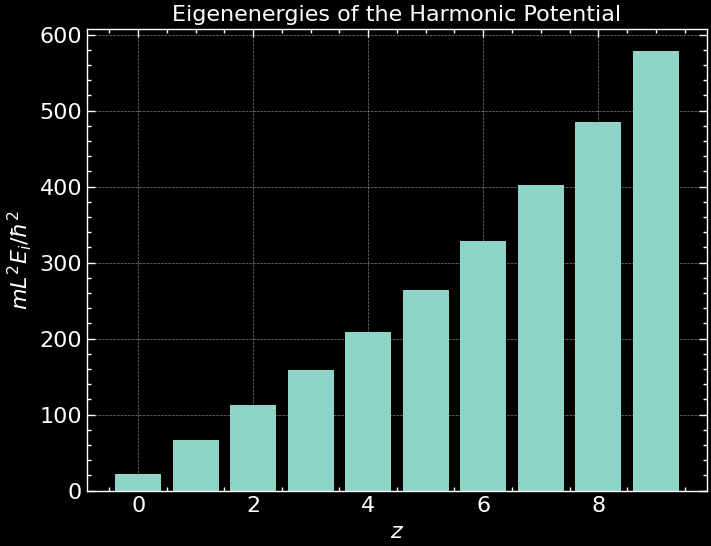

In [9]:
plt.bar(np.arange(0, 10, 1), w[0:10])

plt.title('Eigenenergies of the Harmonic Potential')
plt.xlabel(r'$z$')
plt.ylabel(r'$mL^2E_i/\hbar^2$')

Further, let's consider a Gaussian Spike of the form $$V\propto\exp\bigg[-\frac{(x-0.7)^2}{2\sigma^2}\bigg]$$ where $\sigma=0.05$, instead of the Harmonic Potential and see how it goes from there:

Text(0, 0.5, '$mL^2V(z)$ [V kg $\\mathrm{m}^2$]')

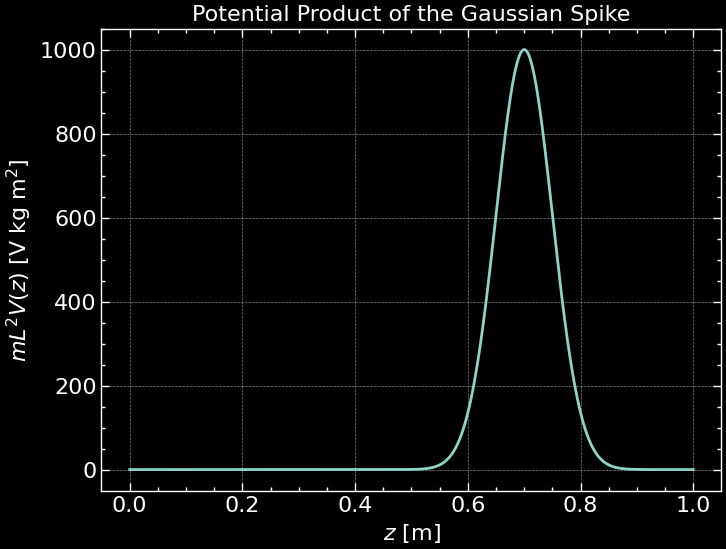

In [10]:
def pot_prod(z):
    return 1000 * np.exp(-(z - 0.7) ** 2 / (2 * 0.05 ** 2))

plt.plot(z, pot_prod(z))
plt.title('Potential Product of the Gaussian Spike')
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$mL^2V(z)$ [V kg $\mathrm{m}^2$]')

In [11]:
d = dz ** (-2) + pot_prod(z)[1:-1]
e = -0.5 * dz ** (-2) * np.ones(len(d) - 1)

w, v = eigh_tridiagonal(d, e)
v

array([[ 1.00343420e-04, -1.99257202e-04,  8.56522783e-07, ...,
         2.32173143e-05, -1.03035447e-09,  4.39179725e-14],
       [ 2.00686206e-04, -3.98509403e-04,  1.71300535e-06, ...,
        -4.64346754e-05,  2.06083998e-09, -8.78517891e-14],
       [ 3.01027727e-04, -5.97751606e-04,  2.56940750e-06, ...,
         6.96521298e-05, -3.09158756e-09,  1.31817300e-13],
       ...,
       [ 9.87111331e-08,  5.97366909e-07,  1.33187187e-03, ...,
         2.90589216e-04,  2.55942217e-05,  5.23615259e-07],
       [ 6.58077680e-08,  3.98252933e-07,  8.87949317e-04, ...,
        -1.93725819e-04, -1.70610064e-05, -3.48971929e-07],
       [ 3.29039878e-08,  1.99128965e-07,  4.43985080e-04, ...,
         9.68628120e-05,  8.52996084e-06,  1.74454496e-07]])

And finally, the Eigenfunctions, Probability Denisties and Eigenenergies:

Text(0, 0.5, '$\\psi_i(z)$')

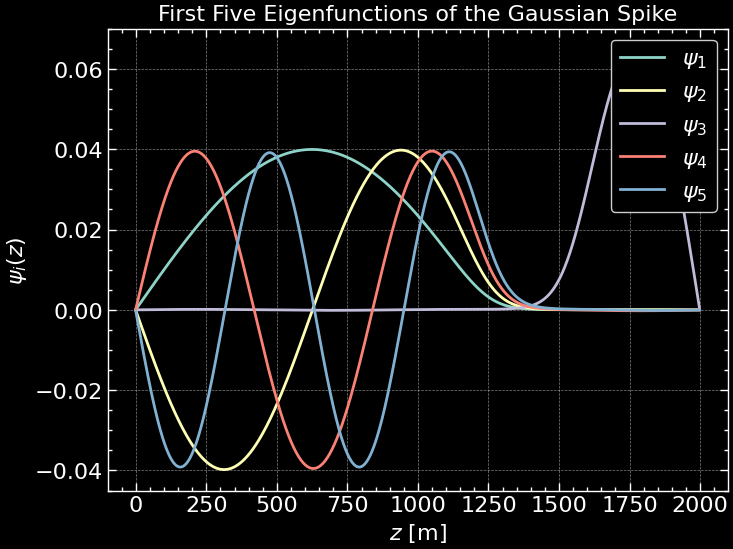

In [12]:
plt.plot(v.T[0], label = r'$\psi_1$')
plt.plot(v.T[1], label = r'$\psi_2$')
plt.plot(v.T[2], label = r'$\psi_3$')
plt.plot(v.T[3], label = r'$\psi_4$')
plt.plot(v.T[4], label = r'$\psi_5$')

plt.title('First Five Eigenfunctions of the Gaussian Spike')
plt.legend()
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$\psi_i(z)$')

Text(0, 0.5, '$|\\psi_i(z)|^2$')

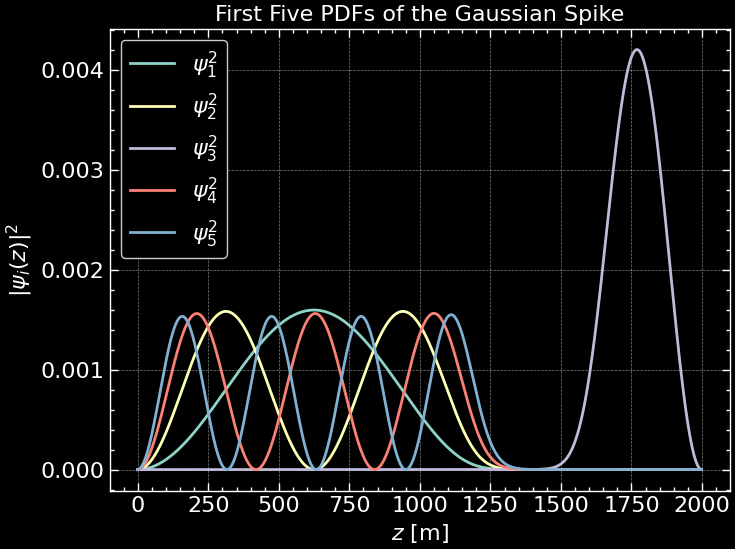

In [13]:
plt.plot(v.T[0] ** 2, label = r'$\psi_1^2$')
plt.plot(v.T[1] ** 2, label = r'$\psi_2^2$')
plt.plot(v.T[2] ** 2, label = r'$\psi_3^2$')
plt.plot(v.T[3] ** 2, label = r'$\psi_4^2$')
plt.plot(v.T[4] ** 2, label = r'$\psi_5^2$')

plt.title('First Five PDFs of the Gaussian Spike')
plt.legend()
plt.xlabel(r'$z$ [m]')
plt.ylabel(r'$|\psi_i(z)|^2$')

Text(0, 0.5, '$mL^2E_i/\\hbar^2$')

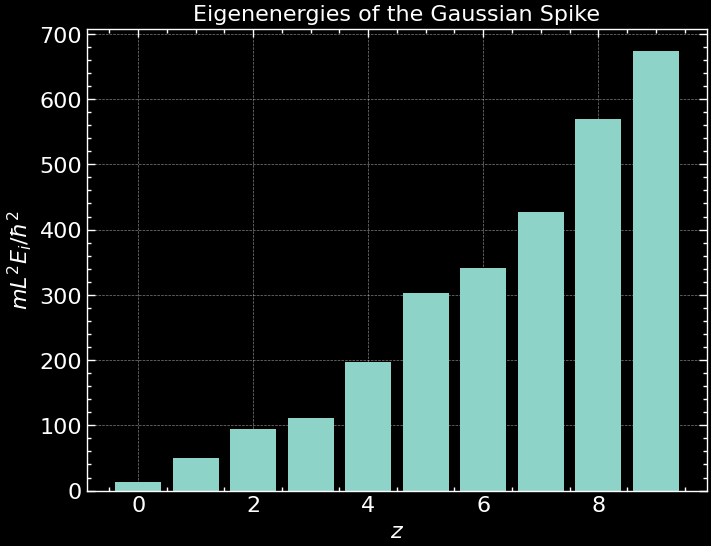

In [14]:
plt.bar(np.arange(0, 10, 1), w[0:10])

plt.title('Eigenenergies of the Gaussian Spike')
plt.xlabel(r'$z$')
plt.ylabel(r'$mL^2E_i/\hbar^2$')

# Numerical Solutions in $\mathbb{R}^2$:

The Time-Independent Schrödinger Equation $$-\frac{\hbar^2}{2m}\Bigg(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\Bigg)\psi+V(x,y)\psi=E\psi$$ can be turned into $$\Bigg[-\frac 12\big(D\otimes D\big)+m\,\delta x^2V\Bigg]\psi=\big(m\,\delta x^2 E\big)\psi$$ using discretization and a Kronecker Sum, where 
- The matrix $D$ has $-2$ on its main diagonal, and $1$ on the two neighbouring ones,
- $\psi$ is a vector.

Let's now make a meshgrid of $x$ and $y$ values, and define our potential in units of $m\,\delta x^2$ so that we can return $m\,\delta x^2V$ using a `potential` function.

In [19]:
N = 150
X, Y = np.meshgrid(np.linspace(0, 1, N, dtype = float), np.linspace(0, 1, N, dtype = float))

X

array([[0.        , 0.00671141, 0.01342282, ..., 0.98657718, 0.99328859,
        1.        ],
       [0.        , 0.00671141, 0.01342282, ..., 0.98657718, 0.99328859,
        1.        ],
       [0.        , 0.00671141, 0.01342282, ..., 0.98657718, 0.99328859,
        1.        ],
       ...,
       [0.        , 0.00671141, 0.01342282, ..., 0.98657718, 0.99328859,
        1.        ],
       [0.        , 0.00671141, 0.01342282, ..., 0.98657718, 0.99328859,
        1.        ],
       [0.        , 0.00671141, 0.01342282, ..., 0.98657718, 0.99328859,
        1.        ]])

In [20]:
def potential(x, y):
    return 0 * x

V = potential(X, Y)

Now let's construct $$-\frac 12\big(D\otimes D\big)+m\,\delta x^2V$$ Let $T=-1/2\big(D\otimes D\big)$ and $U=2m\,\delta x^2V$.

In [21]:
diag = np.ones([N])
diags = np.array([diag, -2 * diag, diag])

diags

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       

In [22]:
D = sparse.spdiags(diags, np.array([-1, 0, 1]), N, N)

T = -0.5 * sparse.kronsum(D, D)
U = sparse.diags(V.reshape(N ** 2), (0))

H = T + U

In [23]:
eigenvalues, eigenvectors = eigsh(H, k = 10, which = 'SM')
eigenvalues

array([0.00043284, 0.00108201, 0.00108201, 0.00173118, 0.00216365,
       0.00216365, 0.00281282, 0.00281282, 0.00367729, 0.00367729])

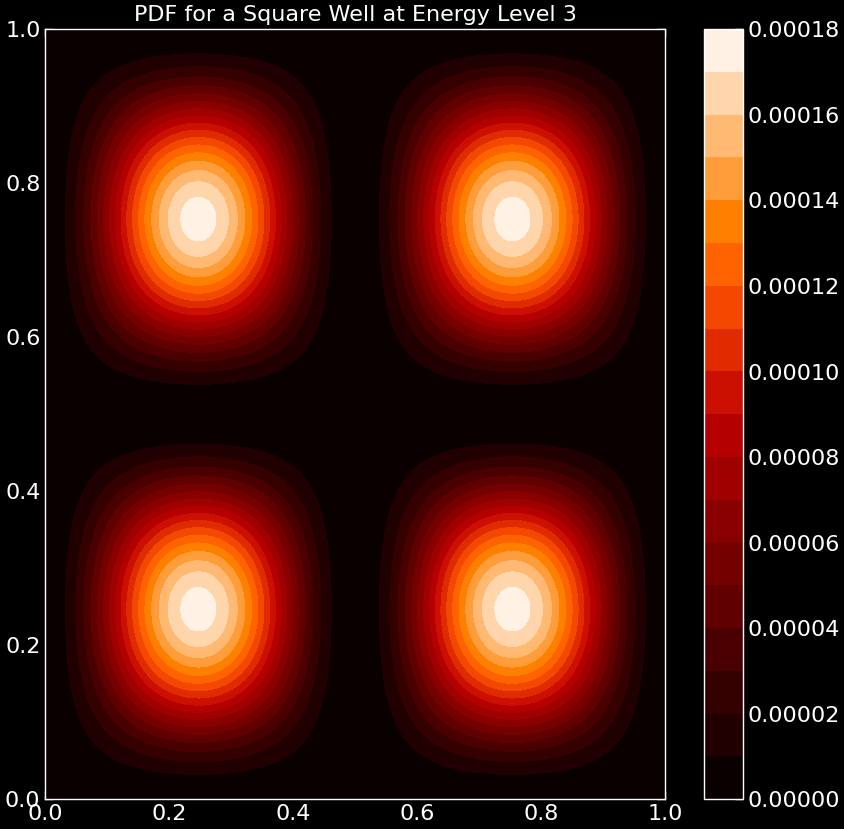

In [24]:
def e(n):
    return eigenvectors.T[n].reshape((N, N))

energy_level = 3 # CHANGE THIS AS YOU PLEASE

plt.figure(figsize = (10, 10))
plt.contourf(X, Y, e(energy_level) ** 2, 20, cmap = 'gist_heat')
plt.title('PDF for a Square Well at Energy Level {}'.format(energy_level))
plt.colorbar()

# Animation:

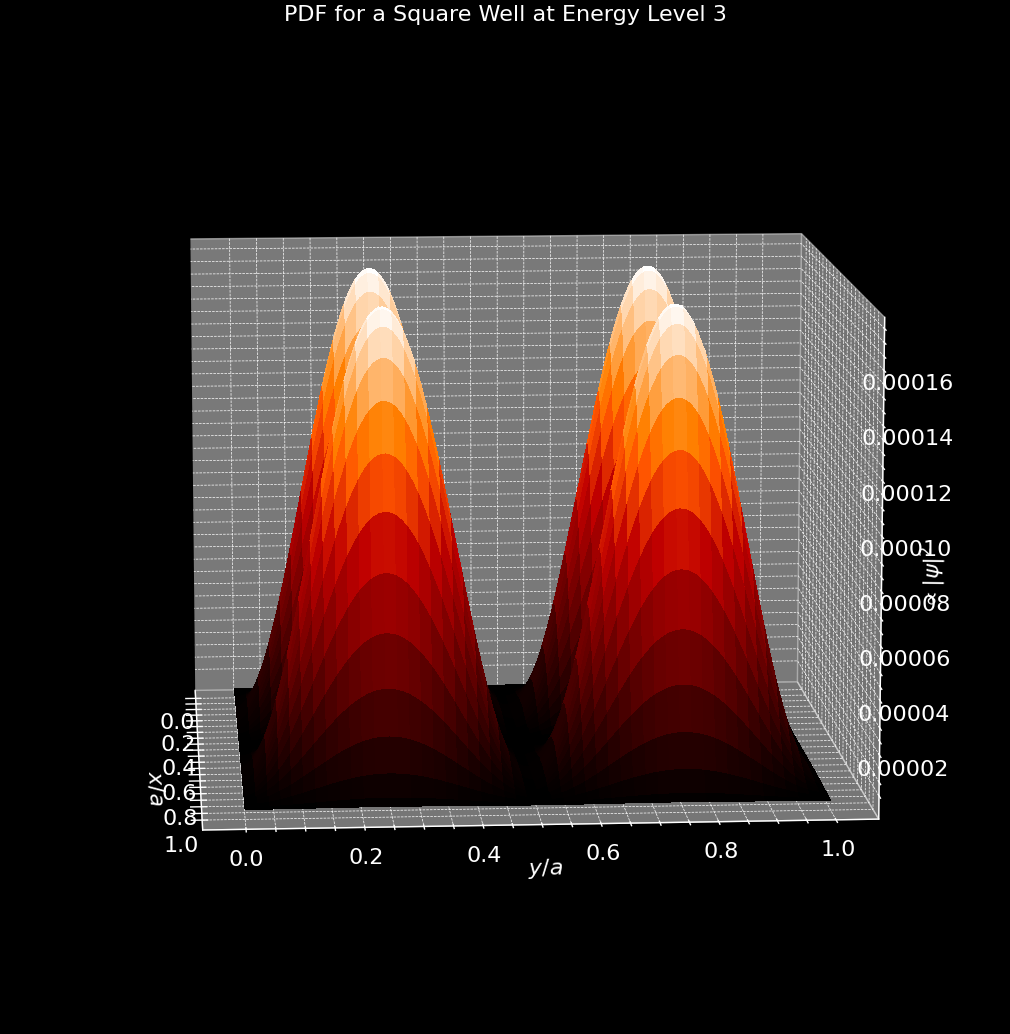

In [27]:
my_cmap = plt.get_cmap('gist_heat')

def init():
    ax.plot_surface(X, Y, e(energy_level) ** 2, cmap = my_cmap, linewidth = 0, antialiased = False)

    ax.set_title(r'PDF for a Square Well at Energy Level {}'.format(energy_level))

    ax.set_xlabel(r'$x/a$')
    ax.set_ylabel(r'$y/a$')
    ax.set_zlabel('$\propto|\psi|^2$')

    return fig,

def animate(i):
    ax.view_init(elev = 10, azim = 4 * i)
    return fig,

fig = plt.figure(figsize = (10, 10))
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)

ani = animation.FuncAnimation(fig, animate, init_func = init, frames = 90, interval = 50)
ani.save('../Outputs/pdf_square-well.gif', writer = 'pillow')

What's noteworthy is that $E_{n_x,n_y}=\alpha\,(n_x^2+n_y^2)$, and the first eigenenergy is when both $n_{\vec x}=1$. This means that we can find $\alpha$, half the lowest eigenenergy, and $E/\alpha$ would be distributed like $n_x^2+n_y^2$ for different $n_{\vec x}$ values.

Text(0, 0.5, '$E/\\alpha$')

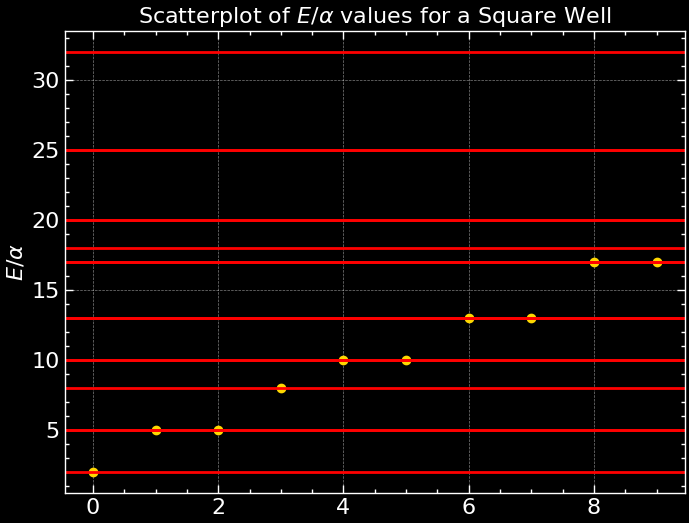

In [29]:
alpha = eigenvalues[0] / 2
ratio = eigenvalues / alpha

_ = np.arange(0, len(eigenvalues), 1)
plt.scatter(_, ratio, color = 'gold')
[plt.axhline(nx ** 2 + ny ** 2, color = 'red') for nx in range(1, 5) for ny in range(1, 5)]

plt.title(r'Scatterplot of $E/\alpha$ values for a Square Well')
plt.ylabel(r'$E/\alpha$')

Again, we'll tackle another Gaussian Spike in addition to this, of the form $$V\propto\exp\bigg[-\frac{(x-0.3)^2}{2\sigma^2}\bigg]\exp\bigg[-\frac{(y-0.3)^2}{2\sigma^2}\bigg]$$ where $\sigma=0.1$.

In [28]:
def potential(x, y):
    return np.exp(-(x - 0.3) ** 2 / (2 * 0.1 ** 2)) * np.exp(-(y - 0.3) ** 2 / (2 * 0.1 ** 2))

V = potential(X, Y)

In [29]:
diag = np.ones([N])
diags = np.array([diag, -2 * diag, diag])

In [30]:
D = sparse.spdiags(diags, np.array([-1, 0, 1]), N, N)

T = -0.5 * sparse.kronsum(D, D)
U = sparse.diags(V.reshape(N ** 2), (0))

H = T + U

In [31]:
eigenvalues, eigenvectors = eigsh(H, k = 10, which = 'SM')
eigenvalues

array([0.00103169, 0.00166184, 0.00202522, 0.00278261, 0.0030786 ,
       0.00401444, 0.00446742, 0.0051308 , 0.00524703, 0.00574824])

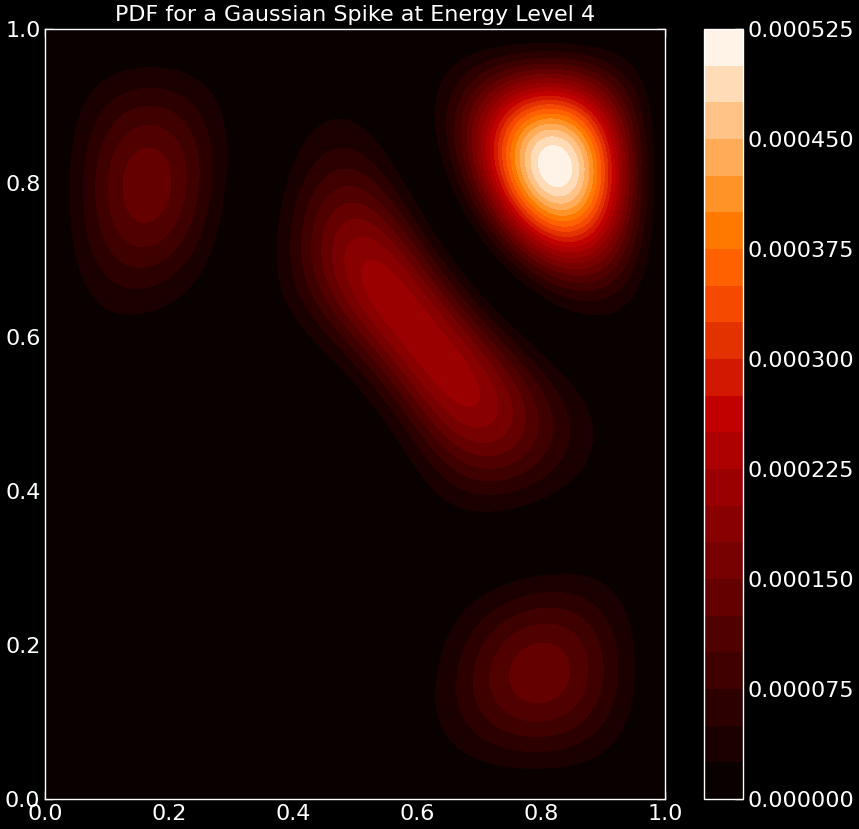

In [32]:
def e(n):
    return eigenvectors.T[n].reshape((N, N))

energy_level = 4 # CHANGE THIS AS YOU PLEASE

plt.figure(figsize = (10, 10))
plt.contourf(X, Y, e(energy_level) ** 2, 20, cmap = 'gist_heat')
plt.title('PDF for a Gaussian Spike at Energy Level {}'.format(energy_level))
plt.colorbar()

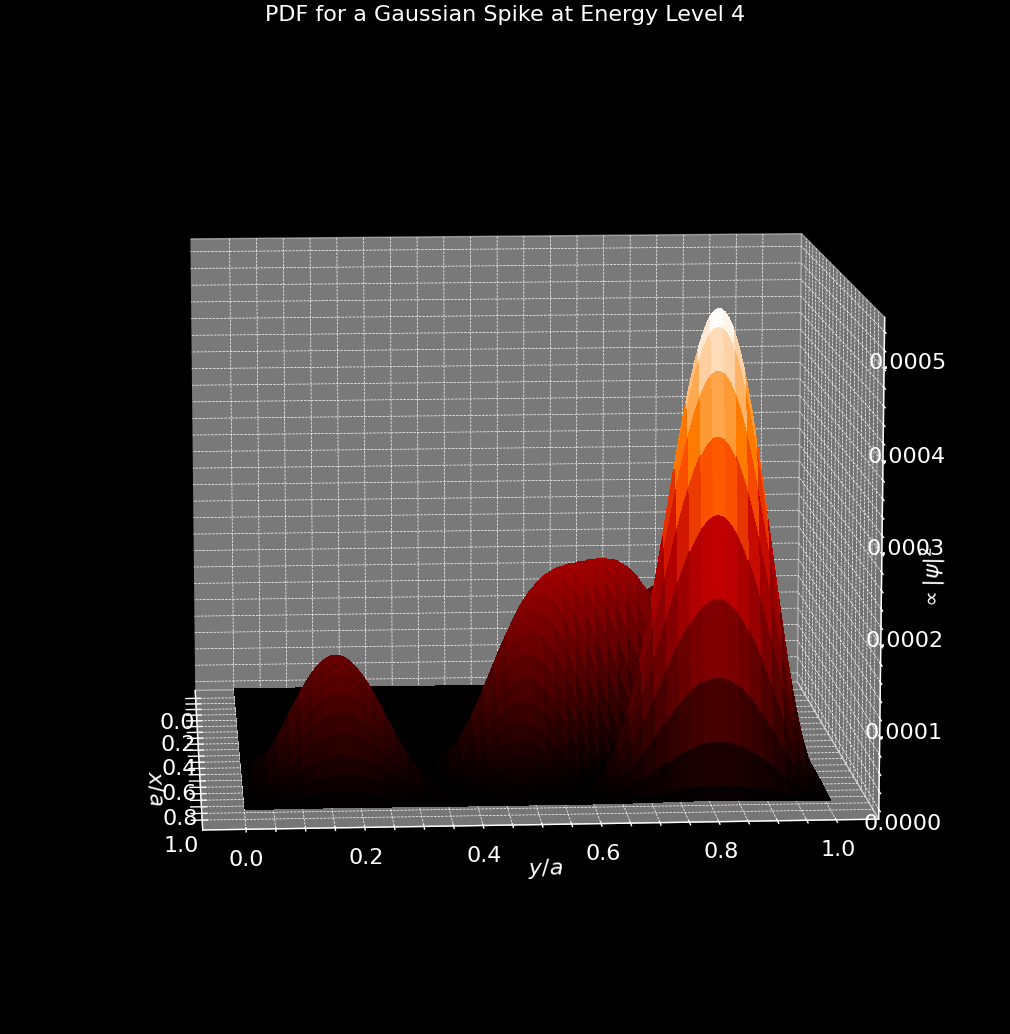

In [33]:
my_cmap = plt.get_cmap('gist_heat')

def init():
    ax.plot_surface(X, Y, e(energy_level) ** 2, cmap = my_cmap, linewidth = 0, antialiased = False)

    ax.set_title('PDF for a Gaussian Spike at Energy Level {}'.format(energy_level))

    ax.set_xlabel(r'$x/a$')
    ax.set_ylabel(r'$y/a$')
    ax.set_zlabel('$\propto|\psi|^2$')

    return fig,

def animate(i):
    ax.view_init(elev = 10, azim = 4 * i)
    return fig,

fig = plt.figure(figsize = (10, 10))
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)

ani = animation.FuncAnimation(fig, animate, init_func = init, frames = 90, interval = 50)
ani.save('../Outputs/pdf_g-spike.gif', writer = 'pillow')

Text(0, 0.5, '$E/\\alpha$')

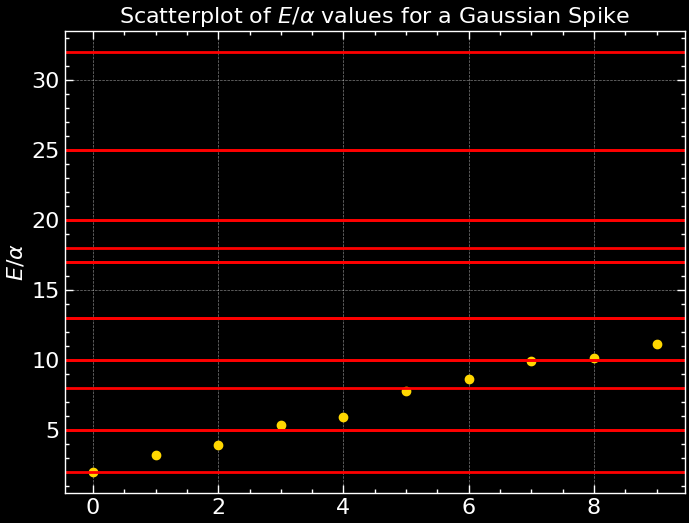

In [43]:
alpha = eigenvalues[0] / 2
ratio = eigenvalues / alpha

_ = np.arange(0, len(eigenvalues), 1)
plt.scatter(_, ratio, color = 'gold')
[plt.axhline(nx ** 2 + ny ** 2, color = 'red') for nx in range(1, 5) for ny in range(1, 5)]

plt.title(r'Scatterplot of $E/\alpha$ values for a Gaussian Spike')
plt.ylabel(r'$E/\alpha$')